In [2]:
!pip install funpymodeling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 215 kB 19.3 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=75a54f50ca0adacfcf052b5214e46730e73ac7e34ca1a53c114de23f77f91f80
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [1]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
pd.options.display.float_format = '{:.2f}'.format
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import seaborn as sns

# ver que sirve de acá
from funpymodeling.exploratory import status, freq_tbl, profiling_num
from funpymodeling.data_prep import todf


Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
pandas version: 1.3.5
NumPy version: 1.21.6


In [2]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=9)
    hist_ax.set_title('Histograma')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [3]:
#Vamos a Definir Fecha , "Y" y Tipo
#Dentro de los primeros análisis esta  validar el formato fecha( europeo ,americano, corroborar los tipos de los atributos y el formato de la tabla)
#Al definir estos nombres aca solo tendremos que modificar la mayor cantidad de código en esta parte ya que trabajaremos con los nombres Fecha y Y a lo largo del notebook

 
#Vamos a Definir Fecha , "Y" y serie(buscar un mejor nombre) en caso de que tengamos que predecir más de una serie en  la misma tabla
#Definir atributos extras para variables externas ...ej: día con promoción, feriado, precio commodity, clima etc.


data=pd.read_csv('sessionDicsys22.csv')
data=data.rename(columns={"date": "FECHA", "newUsers": "y"})
data['FECHA']=pd.to_datetime(data['FECHA'])

#data2 = data[(data['sessionSource']=="(direct)") & (data['sessionSource']=="/")]
data2=data[ ['FECHA','y']]
data2.set_index('FECHA', inplace=True)
data.head(3)

#Si es una sola serie



,Unnamed: 0,sessionSource,pagePath,FECHA,sessions,y,conversions
0,0,(direct),/,2022-01-10,1371,1374,0
1,1,(direct),/,2022-01-05,508,507,0
2,2,(direct),/,2022-01-04,381,374,0


In [4]:
data2.head()

,y
FECHA,
2022-01-10,1374
2022-01-05,507
2022-01-04,374
2022-01-07,378
2022-01-06,245


In [5]:
# como se repetia la fecha por estar dividido por canales/ redes agrupamos por fecha
test = data2.groupby(['FECHA']).sum()['y']
test=test.reset_index()
test

,FECHA,y
0,2022-01-01,106
1,2022-01-02,2
2,2022-01-03,236
3,2022-01-04,382
4,2022-01-05,520
...,...,...
208,2022-07-28,39
209,2022-07-29,122
210,2022-07-30,9
211,2022-07-31,10


In [6]:
data= test
data2=test

## 1° ANALISIS EXPLORATORIO 

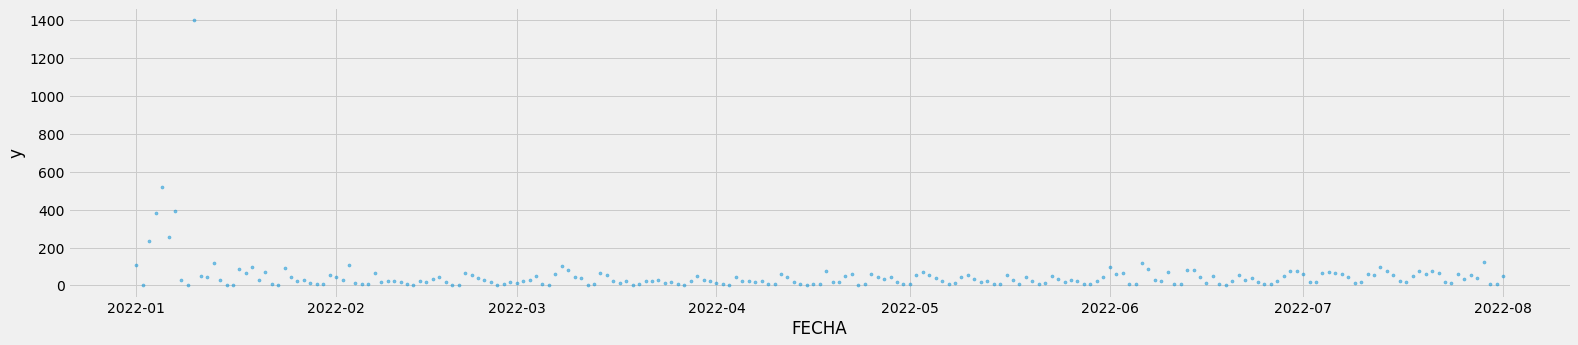

In [7]:
#Observar valores nulos y ceros y hacer una primera grafica.
#puede que tengamos varios registros en un mismo dia .Por lo tanto es interesante ver tanto un scatterchart como un grafico de linea
fig, ax = plt.subplots(figsize=(24,5))
data.plot(kind='scatter', x='FECHA', y='y', ax=ax, s=10, alpha=0.5)
#sns.scatterplot(data=data, x="importeD", y="Tns",hue="PRODUCTO")

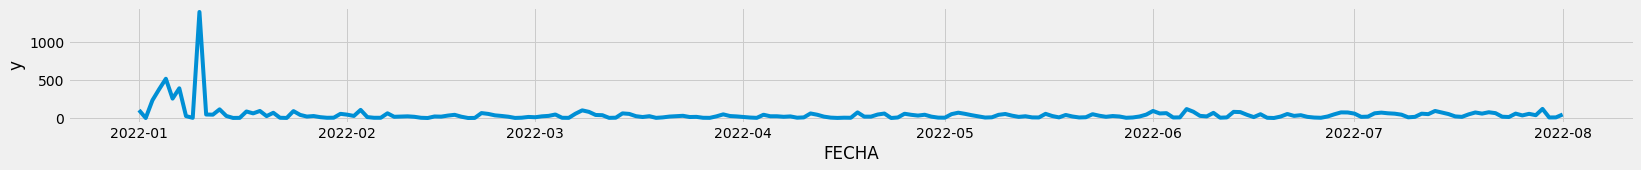

In [8]:
fig, ax = plt.subplots(figsize=(25,2))
sns.lineplot(data=data, x="FECHA", y="y")


In [9]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,FECHA,0,0.00,0,0.00,213,datetime64[ns]
1,y,0,0.00,0,0.00,86,int64


In [10]:
data.FECHA.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     213
unique                    213
top       2022-01-01 00:00:00
freq                        1
first     2022-01-01 00:00:00
last      2022-08-01 00:00:00
Name: FECHA, dtype: object

In [11]:
data.y.describe()

count    213.00
mean      48.35
std      109.98
min        2.00
25%       11.00
50%       26.00
75%       56.00
max     1402.00
Name: y, dtype: float64

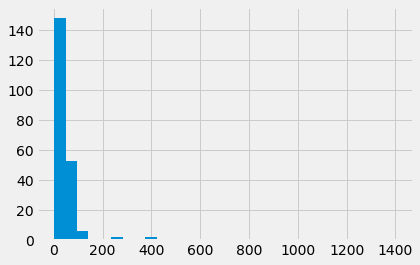

In [12]:
#importante probar con distinta cantidad de bins
data.y.hist(bins=30)

Luego de estas dos graficas y  ver valores nulos y ceros Se pueden contestar ciertas preguntas:

(En esta primer instacia lo vamos a simplicar a Fecha , producto  y serie)

Rango de fecha : 01/ 2022 - 08 /2022

Cantidad de dias unicos: 213

Tiene sentido la cantiad de dias distintos en ese rango 

Faltan fechas?

------------------------------------
Hay valores nulos ? no

Hay valores 0? no
hay valore negativos? no

cual es el valor minimo y maximo de y : Aca podemos observar un pico maximo en Enero inusual, (se eliminara este dato del analisis) y un minimo del 2% en relacion a la mediana del 26%, se encuentra en valores "normales"

------------------------sobre estas preguntas peguntarse si tiene sentido 
Que podemos decir del histograma.

Si hay mas de una serie :
Las series estan en el mismo rango de valores ?
Cuantas series hay?
Si son muchas ver cuanto representa la suma de y
(Esto sirve para saber que enfoque de modelos usar.Modelos especificos para un grupo reducido. O "un" modelo para todas las series.
Ej : SI un store representa el 90% de la facturacion tiene sentido hacer un modelo especifico este store y para el resto usar un modelo general) 



(FALTARIA AGREGAR LO DE NORMALIZAR la unidad de medida )

In [13]:
#En funcion de las preguntas anteriores.hacer uan primera limpieza del dataset  y dejar registradas las validaciones para hacer con el cliente

#solo aplico un filtro de ejemplo

df = test

## ANALISIS ESTADISTICOS PROFUNDOS DE LAS SERIES TEMPORALES

In [14]:
data2=data2.set_index('FECHA')

In [ ]:
df = data2.resample('m').agg({'y': 'sum'})
tsplot(df,3)

In [ ]:
df = data2.resample('w').agg({'y': 'sum'})
tsplot(df,14)

In [ ]:
df = data2.resample('d').agg({'y': 'sum'})
tsplot(df,14)

In [ ]:
df = data2.resample('y').agg({'y': 'sum'})
df=df.reset_index()
fig, ax = plt.subplots(figsize=(25,2))
sns.lineplot(data=df, x="FECHA", y="y")
ax.set_title('tendencia anual', fontsize=18); 

In [ ]:

df = data2.resample('d').agg({'y': 'sum'})
df=df.reset_index()

# agregamos datos años y meses
df['year'] = [d.year for d in df.FECHA]
df['mes'] = [d.strftime('%b') for d in df.FECHA]
years = df['year'].unique()


fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='y', data=df, ax=axes[0])
sns.boxplot(x='mes', y='y', data=df.loc[~df.year.isin([2013, 2015]), :])

# titulo
axes[0].set_title('Box Plot año a año \n (tendencia anual)', fontsize=18); 
axes[1].set_title('Box Plot mes a mes\n(estacionalidad)', fontsize=18)
plt.show()

In [ ]:
import statsmodels.api as sm
from pylab import rcParams

df = data2.resample('w').agg({'y': 'sum'})
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive',period=12)
fig = decomposition.plot()
plt.show()

In [ ]:
import matplotlib

In [ ]:
#Falta agregar una parte para tratar con outliers. Para empezar un kernel density, pero no alcanzaría.agregar otros tipos de test
